In [221]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
#plt.rcParams['figure.figsize'] = (6, 6)

In [206]:
numerator = np.array([4,-1,20]) #4x**2-x+20
denumerator = np.array([4,1])
simple_model = lambda x:(np.dot(np.array([x**i for i in range(len(numerator)-1, -1, -1)]), numerator))/ \
                          (np.dot(np.array([x**i for i in range(len(denumerator)-1, -1, -1)]), denumerator))

In [220]:
class PID(object):
    """
    Discrete PID control
    """

    def __init__(self, set_point, P=2.0, I=0.0, D=1.0, integrator_max=500, integrator_min=-500):

        self.Kp=P
        self.Ki=I
        self.Kd=D
        
        self._out_max=integrator_max
        self._out_min=integrator_min

        self.set_point=set_point
        self.last_value = 0.0
        self.error=0.0
        self.integral = 0.0
        self.prev_error = 0.0

    def update(self,current_value, dt=1):
        """
        Calculate PID output value for given reference input and feedback
        assumes each step is one time step
        """

        self.error = self.set_point - current_value

        # In order to prevent windup, only integrate if the process is not saturated
        if self.last_value < self._out_max and self.last_value > self._out_min:
            self.integral = self.integral + self.error * dt
            self.integral = min(self.integral, self._out_max)
            self.integral = max(self.integral, self._out_min)
        
        self.derivative = (self.error - self.prev_error) / dt

        PID = self.Kp * self.error + self.Ki * self.integral + self.Kd * self.derivative
        self.last_value = PID
        self.prev_error = self.error

        return PID

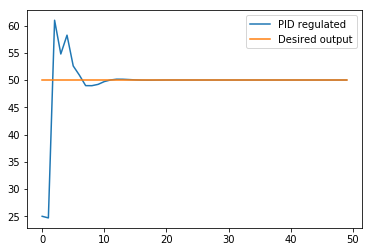

In [219]:
REQUESTED_VAL = 50.0
STEPS = 50
pid_controller = PID(REQUESTED_VAL, P=0.65, I=0.6, D=0.2)
model_val = 25.00
model_values = [model_val]
for t in range(1,STEPS):
    model_val = simple_model(model_val)
    model_values.append(model_val)
    model_val += pid_controller.update(model_val)
plt.plot(range(STEPS), model_values, label="PID regulated")    
plt.plot(range(STEPS), [REQUESTED_VAL]*STEPS, label="Desired output")
plt.legend()

In [229]:
class LQR(object):
    """
    Discrete LQR control
    """

    def __init__(self, Q=np.eye(2), R=np.eye(1)):

        self.Kopt = 0.0
        self.Q = Q
        self.R = R

    def calc_kopt(self, Ad, Bd, dt=1.0):
        """Solve the discrete time lqr controller.
        x[k+1] = Ad x[k] + Bd u[k]
        cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
        # ref Bertsekas, p.151
        """
        n = len(Bd)
        # continuous
        Ac = (Ad - np.eye(n)) / dt
        Bc = Bd / dt
        # Hamiltonian
        Ham = np.vstack(
            (np.hstack((Ac, - Bc * la.inv(self.R) * Bc.T)),
             np.hstack((-self.Q, -Ac.T))))
        eigVals, eigVecs = la.eig(Ham)

        V1 = None
        V2 = None
        for i in range(2 * n):
            if eigVals[i].real < 0:
                if V1 is None:
                    V1 = eigVecs[0:n, i]
                    V2 = eigVecs[n:2 * n, i]
                else:
                    V1 = np.vstack((V1, eigVecs[0:n, i]))
                    V2 = np.vstack((V2, eigVecs[n:2 * n, i]))
        V1 = np.matrix(V1.T)
        V2 = np.matrix(V2.T)
        P = (V2 * la.inv(V1)).real
        K = la.inv(self.R) * Bc.T * P
        self.Kopt = K
        return K

    def do_step(self,x):
        u = -self.Kopt * x
        return u
# see also MPC (process has 2 params-past+control signal, minimize control signal)

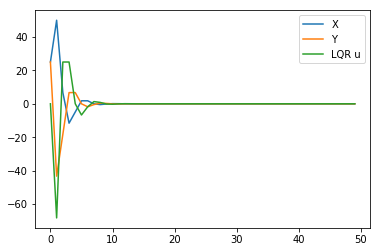

In [266]:
A = np.matrix([[1.0, 1.0], [0, 1.0]])
B = np.matrix([0.0, 1.0]).T
def process(x, u): #LQR tries to regulate the process
    x = A * x + B * u
    return (x)

lqr_controller = LQR(Q= np.matrix([[1.0, 0.0], [0.0, 1.0]]), R=np.eye(1))
lqr_controller.calc_kopt(A, B)

REQUESTED_VAL = 50.0
STEPS = 50
model_val = x = np.matrix([25, 25]).T
model_values_x = [model_val[0,0]]
model_values_y = [model_val[1,0]]
control_inputs = [0]
for t in range(1,STEPS):
    u = lqr_controller.do_step(model_val)
    model_val = process(model_val, u[0, 0])
    model_values_x.append(model_val[0,0])
    model_values_y.append(model_val[1,0])
    control_inputs.append(u)
plt.plot(range(STEPS), model_values_x, label="X")
plt.plot(range(STEPS), model_values_y, label="Y")
plt.plot(range(STEPS), control_inputs, label="LQR u")
plt.legend()